# Preliminary Results


In [19]:
# Load the necessary packages.
library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

In [3]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
download.file (url,"../data/forestfires.csv" )

forest_fires_data <-read_delim("../data/forestfires.csv", skip=0, delim=",") %>%
    select(month, wind, area) %>%
    mutate(month = as.factor(month), wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(month) | !is.na(wind) | !is.na(area))
    
head(forest_fires_data)


Rows: 517 Columns: 13
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


month,wind,area
<fct>,<dbl>,<dbl>
mar,6.7,0
oct,0.9,0
oct,1.3,0
mar,4.0,0
mar,1.8,0
aug,5.4,0


##### Table 1: Top 6 Rows of Forest Fires Data

##### Table 2: Summary Statistics of Forest Fires Data

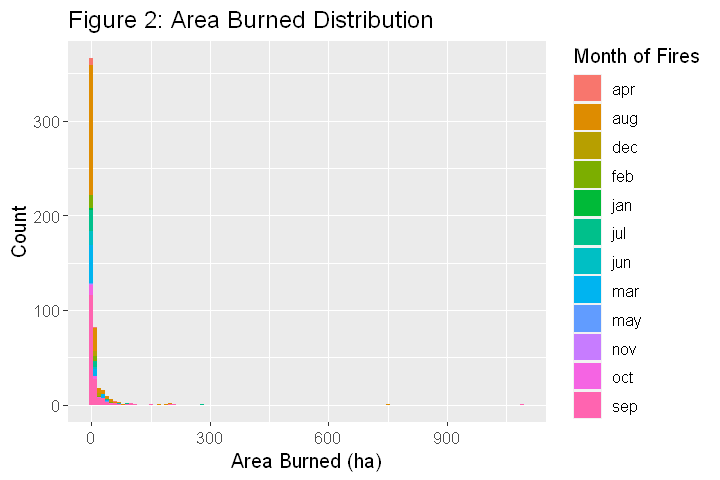

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4)

#Visualizing the distribution of each variable
area_burned_plot <- forest_fires_data %>%
    ggplot(aes(x =area, fill = month))+
    geom_histogram(binwidth = 10) + 
    labs(x="Area Burned (ha)", y="Count")+
    ggtitle("Figure 2: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12))
area_burned_plot

Figure 2 shows that it make sense to scale the data in a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [27]:
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(1+ area))

Warning message:
"Removed 247 rows containing non-finite values (`stat_bin()`)."


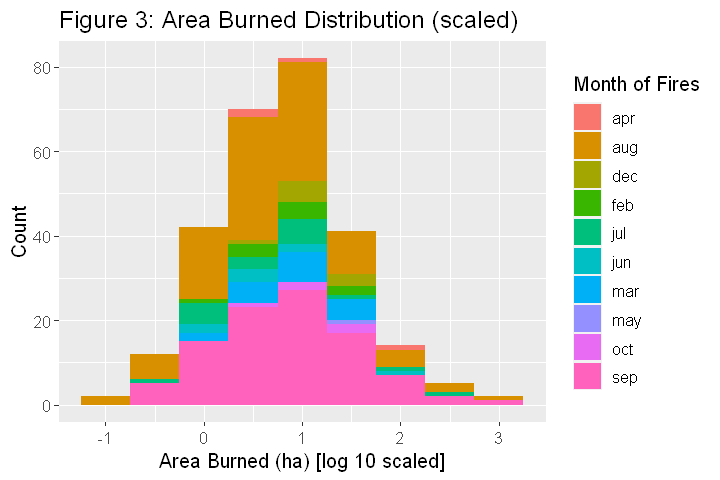

In [7]:
area_burned_scaled_plot <- forest_fires_data %>%
    ggplot(aes(x =area_log10, fill = month))+
    geom_histogram(binwidth = 0.5) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 3: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12))
area_burned_scaled_plot

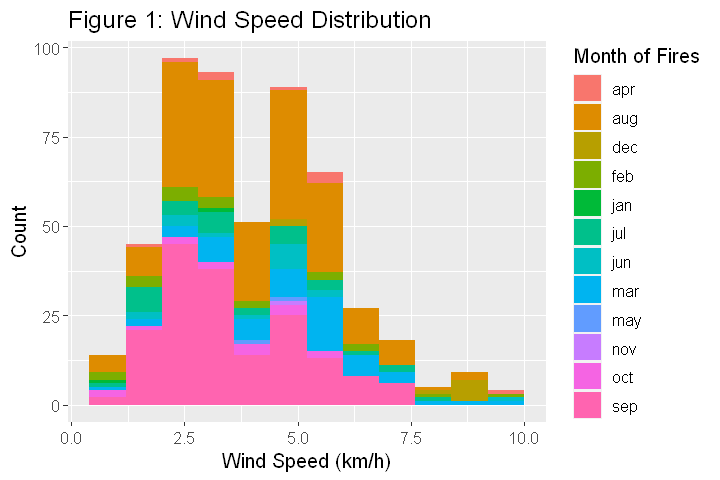

In [8]:
wind_speed_plot <- forest_fires_data %>%
    ggplot(aes(x = wind, fill = month))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 1: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12)) 
wind_speed_plot

Based on that wind speed is almost a normal distribution (without much modification), we can safely assume that we can categorize wind speed into "high" and "low".

In [9]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))
head(forest_fires_data)

month,wind,area,area_log10,category
<fct>,<dbl>,<dbl>,<dbl>,<fct>
mar,6.7,0,-Inf,high
oct,0.9,0,-Inf,low
oct,1.3,0,-Inf,low
mar,4.0,0,-Inf,low
mar,1.8,0,-Inf,low
aug,5.4,0,-Inf,high


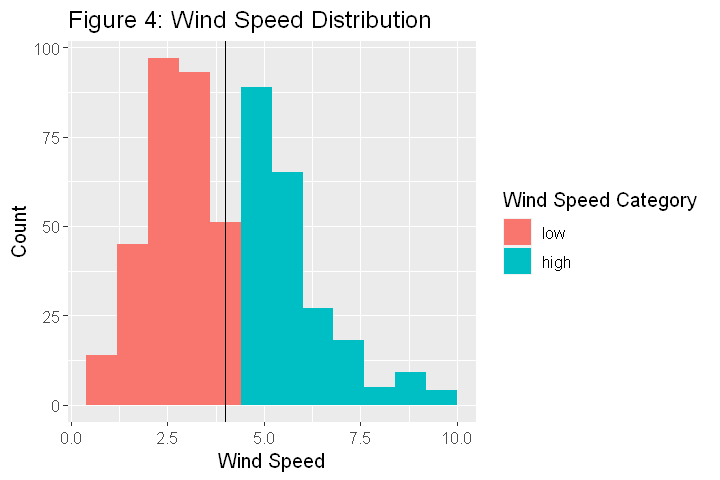

In [10]:
wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x =wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed", y="Count")+
    ggtitle("Figure 4: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))
wind_plot_categorized

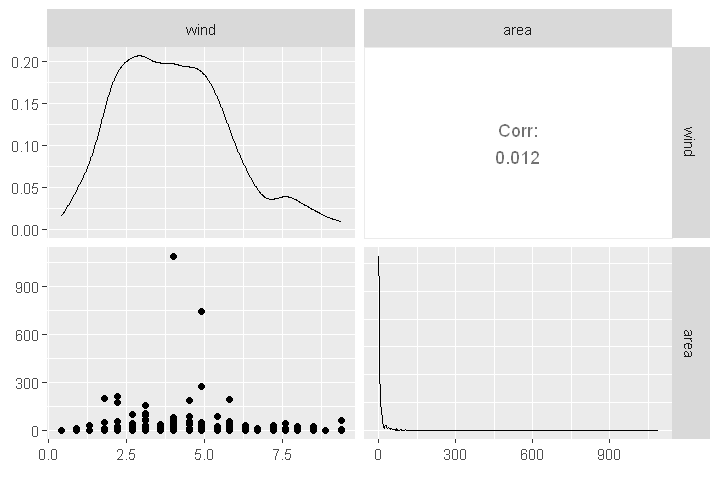

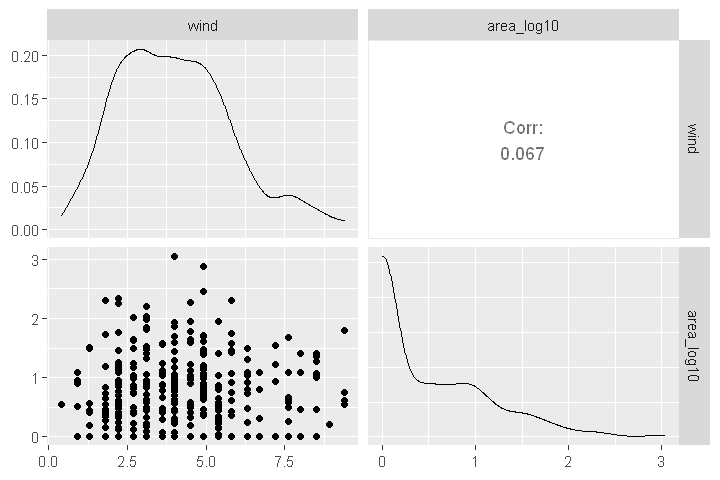

In [28]:
ggpairs(forest_fires_data%>% select(wind, area))
ggpairs(forest_fires_data %>% select(wind, area_log10))

In [33]:
forest_fires_data %>%
group_by(category) %>%
filter(category == "low") %>%
summary()

     month          wind            area            area_log10     category  
 sep    :120   Min.   :0.400   Min.   :   0.000   Min.   :0.0000   low :300  
 aug    :103   1st Qu.:2.200   1st Qu.:   0.000   1st Qu.:0.0000   high:  0  
 jul    : 20   Median :2.700   Median :   0.495   Median :0.1746             
 mar    : 19   Mean   :2.779   Mean   :  12.615   Mean   :0.4699             
 feb    : 14   3rd Qu.:3.600   3rd Qu.:   6.365   3rd Qu.:0.8672             
 oct    : 10   Max.   :4.000   Max.   :1090.840   Max.   :3.0382             
 (Other): 14                                                                 

In [34]:
forest_fires_data %>%
group_by(category) %>%
filter(category == "high") %>%
summary()

     month         wind            area          area_log10     category  
 aug    :81   Min.   :4.500   Min.   :  0.00   Min.   :0.0000   low :  0  
 sep    :52   1st Qu.:4.900   1st Qu.:  0.00   1st Qu.:0.0000   high:217  
 mar    :35   Median :5.400   Median :  0.61   Median :0.2068             
 jul    :12   Mean   :5.729   Mean   : 13.17   Mean   :0.5000             
 jun    :10   3rd Qu.:6.300   3rd Qu.:  7.73   3rd Qu.:0.9410             
 dec    : 9   Max.   :9.400   Max.   :746.28   Max.   :2.8735             
 (Other):18                                                               

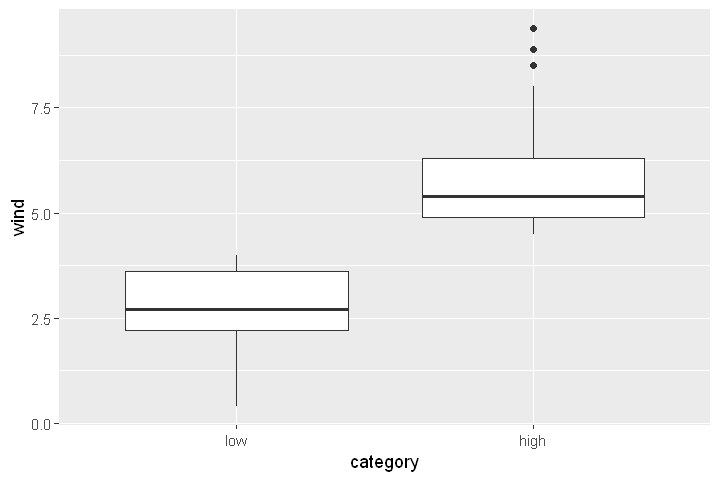

In [38]:
box_plot <- forest_fires_data %>%
  ggplot(aes(x = category, y = wind)) +
  geom_boxplot() 
box_plot